In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

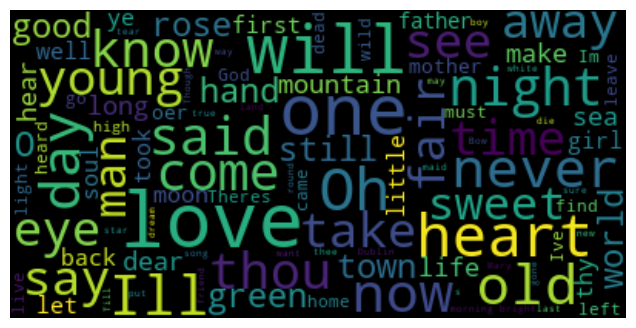

In [2]:


# Abriendo el archivo de texto 
data = open('Data/poem.txt', encoding="utf8").read()
 
# Visualizando el texto sirviendonos de una nube de palabras
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="black").generate(data)
 
# Plotting the WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()

In [3]:
# Generando un corpus separando el texto por saltos de linea
corpus = data.lower().split("\n")
print(corpus[:10])

['stay, i said', 'to the cut flowers.', 'they bowed', 'their heads lower.', 'stay, i said to the spider,', 'who fled.', 'stay, leaf.', 'it reddened,', 'embarrassed for me and itself.', 'stay, i said to my body.']


In [4]:

# Ajustando el tokenizer al corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
 
# Contando las palabras
total_words = len(tokenizer.word_index)
 
print("Total Words:", total_words)

Total Words: 3807


In [5]:

# Treansformando el texto en embeddings
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
 
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences,
                                         maxlen=max_sequence_len,
                                         padding='pre'))
predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
label = ku.to_categorical(label, num_classes=total_words+1)

In [6]:
# Construyendo la arquitectura de la red neuronal

model = Sequential()
model.add(Embedding(total_words+1, 100,
                    input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words+1/2, activation='relu',
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words+1, activation='softmax'))


In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])


In [8]:
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           380800    
                                                                 
 bidirectional (Bidirectiona  (None, 15, 300)          301200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 3807)              384507    
                                                                 
 dense_1 (Dense)             (None, 3808)              14500864  
                                                        

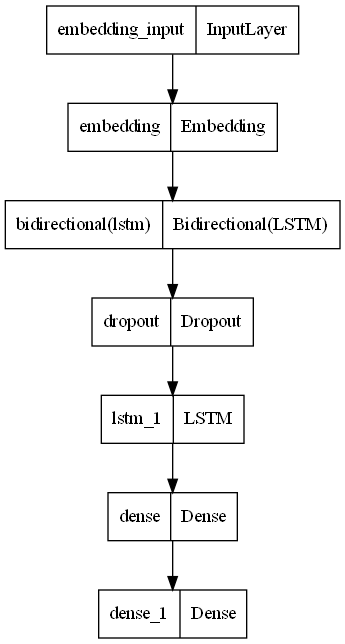

In [9]:
# Visualizando la arquitectura 
ku.plot_model( model ,to_file="model_architecture.png")

In [10]:
# Entrenando el modelo 

history = model.fit(predictors, label, epochs=15, verbose=1)

Epoch 1/15
510/510 [==============================] - 159s 312ms/step - loss: 6.5208 - accuracy: 0.0636
Epoch 2/15
510/510 [==============================] - 160s 314ms/step - loss: 6.3314 - accuracy: 0.0652
Epoch 3/15
510/510 [==============================] - 149s 293ms/step - loss: 6.1971 - accuracy: 0.0741
Epoch 4/15
510/510 [==============================] - 145s 285ms/step - loss: 6.0665 - accuracy: 0.0812
Epoch 5/15
510/510 [==============================] - 163s 320ms/step - loss: 5.9547 - accuracy: 0.0883
Epoch 6/15
510/510 [==============================] - 133s 261ms/step - loss: 5.8360 - accuracy: 0.0966
Epoch 7/15
510/510 [==============================] - 144s 283ms/step - loss: 5.7203 - accuracy: 0.1029
Epoch 8/15
510/510 [==============================] - 140s 274ms/step - loss: 5.6107 - accuracy: 0.1086
Epoch 9/15
510/510 [==============================] - 134s 263ms/step - loss: 5.5069 - accuracy: 0.1153
Epoch 10/15
510/510 [==============================] - 137s 269m

In [13]:
# Guardando el modelo

model.save('saved_language_model/my_model',save_format="h5")

In [18]:
# Generando texto 

seed_text = "My research team are"
next_words = 30
ouptut_text = ""
 
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences(
        [token_list], maxlen=max_sequence_len-1,
      padding='pre')
    predicted = np.argmax(model.predict(token_list,
                                        verbose=0), axis=-1)
    output_word = ""
     
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
             
    seed_text += " " + output_word
     
print(seed_text)

My research team are casey the sea that i was a bow is the sea that i was be a world on a world on the sea that the sea that i was be
